# Criando mapas e visualizando dados geográficos

Este _notebook_ faz parte da 
[análise das expectativas de vida](10_analise_exp-vida_distritos_municipio-SP.ipynb) 
nos diferentes distritos do município de São Paulo. 

**Objetivos** 

Visualizar a expectativa de vida em cada distrito da cidade de São Paulo em um mapa.

**Você vai aprender:**
* Sobre arquivos que armazenam dados geoespaciais, como o [_shapefile_](https://ceweb.br/guias/dados-abertos/capitulo-41/).
* Como carregar esses dados, utilizando o pacote [geopandas](https://geopandas.org/en/stable/).
* Como adicionar informação aos mapas.
* Como visualizar as informações. 

In [2]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import auxiliar.texto as at
import auxiliar.geo as ag

## 1. Carregando os dados

### 1.1. Fronteiras dos distritos da cidade de São Paulo

Mapas e dados georreferenciados do município de São Paulo podem ser obtidos aqui:
<http://geosampa.prefeitura.sp.gov.br>. 

<https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadArquivo.aspx?orig=DownloadCamadas&arq=01_Limites%20Administrativos%5C%5CDistrito%5C%5CShapefile%5C%5CSIRGAS_SHP_distrito&arqTipo=Shapefile>

In [74]:
# Carrega informações geoespaciais dos distritos (fronteiras):
distritos_gdf = gp.read_file('../90_dados/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito.shp')
# Exibe algumas linhas:
distritos_gdf.head()

,ds_codigo,ds_nome,ds_sigla,ds_cd_sub,ds_subpref,ds_areamt,ds_areakmt,geometry
0,51,MANDAQUI,MAN,05,SANTANA-TUCURUVI,1.324786e+07,13.25,"POLYGON ((330950.373 7407837.176, 330952.177 7..."
1,52,MARSILAC,MAR,20,PARELHEIROS,2.081957e+08,208.20,"POLYGON ((336124.090 7355302.282, 336121.755 7..."
2,32,MOEMA,MOE,12,VILA MARIANA,9.079516e+06,9.08,"POLYGON ((331242.174 7392162.324, 331244.581 7..."
3,31,GUAIANASES,GUA,28,GUAIANASES,8.938527e+06,8.94,"POLYGON ((355108.237 7393291.184, 355107.277 7..."
4,33,IGUATEMI,IGU,30,SAO MATEUS,1.958356e+07,19.58,"POLYGON ((350859.949 7389599.855, 350880.182 7..."


### 1.2. Expectativa de vida

Vamos carregar a expectativa de vida que foi calculada no notebook [10_analise_exp-vida_distritos_municipio-SP.ipynb](10_analise_exp-vida_distritos_municipio-SP.ipynb):

In [75]:
# Carrega a expectativa de vida por distrito:
exp_vida_df = pd.read_csv('dados/processados/expectativa-de-vida_distritos-SP.csv')
# Adiciona coluna com nomes iguais aos do mapa, para poder juntar:
exp_vida_df['chave'] = exp_vida_df['distrito'].str.upper().apply(at.remove_acentos)
# Exibe algumas linhas:
exp_vida_df.head()

,distrito,exp_vida_anos,chave
0,Cidade Tiradentes,55.151054,CIDADE TIRADENTES
1,Jardim Ângela,55.486721,JARDIM ANGELA
2,Anhanguera,55.576645,ANHANGUERA
3,Iguatemi,56.504711,IGUATEMI
4,Grajaú,56.624504,GRAJAU


### 1.3. Juntando as duas bases

In [76]:
# Junta a expectativa de vida aos dados geoespaciais:
exp_vida_gdf = distritos_gdf.join(exp_vida_df.set_index('chave'), on='ds_nome')

# Cria legenda (nome do distrito + expectativa de vida) para o mapa:
exp_vida_gdf['legenda'] = exp_vida_gdf['distrito'] + '\n' + exp_vida_gdf['exp_vida_anos'].round(0).astype(int).astype(str)

## 2. Visualizando os dados

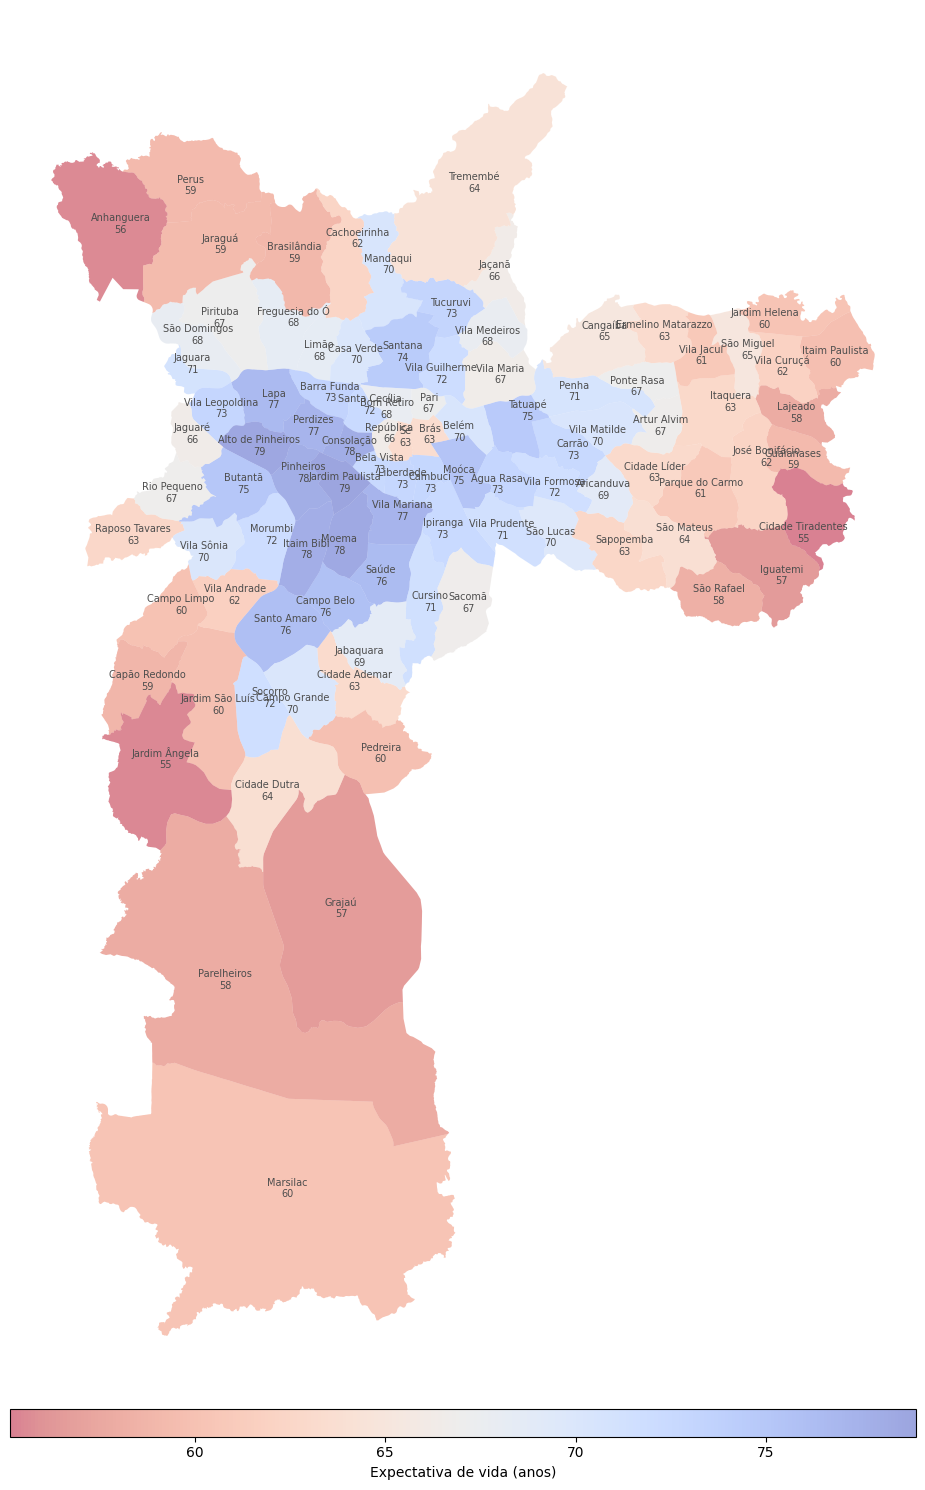

In [77]:
# Cria figura:
fig, ax = pl.subplots(1,1, figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=0.1)
fig.set_facecolor('white')

# Cria o mapa com escala de cor para a expectativa de vida:
exp_vida_gdf.plot(column='exp_vida_anos', ax=ax, alpha=0.5, legend=True, cmap='coolwarm_r', cax=cax, 
                   legend_kwds={'label': 'Expectativa de vida (anos)', 'orientation': 'horizontal', 'alpha': 0.5})

# Adiciona legenda aos distritos (nome e expectativa de vida):
ag.legenda_no_mapa(exp_vida_gdf, 'legenda', 3e2, ax=ax, fontsize=7, color='0.3')

# Finaliza:
ax.axis('off')
pl.tight_layout()
pl.show()

In [78]:
exp_vida_gdf.to_file('/home/hxavier/temp/exp_vida')

/tmp/ipykernel_5180/3941040381.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  exp_vida_gdf.to_file('/home/hxavier/temp/exp_vida')
